# 准备

## 库 导入

In [1]:
try:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn import datasets
    import warnings
    import GEOparse
    from typing import Tuple, List
    from sklearn.metrics import  roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix,fbeta_score
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=42)
    from multiprocessing import Pool, cpu_count
    import ast
except:
    print("Some modules are not loaded")
    %pip install GEOparse
    %pip install imblearn
    %pip install seaborn
    %pip install sklearn
    %pip install pandas
    %pip install numpy
    %pip install matplotlib
    %pip install warnings
    %pip install ast
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn import datasets
    import warnings
    import GEOparse
    from typing import Tuple, List
    from sklearn.metrics import  roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix,fbeta_score
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(random_state=42)
    from multiprocessing import Pool, cpu_count
    import ast

warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LinearRegression, RidgeClassifier, Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, ElasticNet,ElasticNetCV,SGDClassifier,RidgeClassifierCV
from sklearn.svm import SVC, LinearSVC, NuSVC

## 基础设置

In [3]:
GSE_Train = "GSE162330" # 用于训练的数据集
Skip_Paint = True # 是否绘制不必要的绘图


## 数据 导入

In [4]:
GPL10558 = GEOparse.get_GEO(geo="GPL10558", destdir="./datasets", silent=True)

In [5]:
gpl = GEOparse.get_GEO(geo='GPL10558', destdir="./datasets", silent=True)
gsedata = pd.read_pickle("./datasets/GSE162330.pkl")

In [6]:
gsedata.isnull().sum() 

Sample name                      0
organism                         0
characteristics: sample class    0
description                      0
chip name or GEO platform id     0
                                ..
WSB1                             0
CD96                             0
ENOX2                            0
THOC3                            0
CFAP74                           0
Length: 19952, dtype: int64

In [7]:
# drop the rows with missing values more than 50%
gsedata = gsedata.dropna(axis=1, thresh=0.5*len(gsedata.index))
gsedata = gsedata.dropna(axis=0, thresh=0.5*len(gsedata.columns))

gsedata.isnull().sum()

Sample name                      0
organism                         0
characteristics: sample class    0
description                      0
chip name or GEO platform id     0
                                ..
WSB1                             0
CD96                             0
ENOX2                            0
THOC3                            0
CFAP74                           0
Length: 19952, dtype: int64

In [8]:
gsedata['characteristics: sample class'].value_counts() # 看一下感染这个列的分布

v    1069
c     467
b     215
Name: characteristics: sample class, dtype: int64

## 函数 准备

#### 定义存储结果的DataFrame

In [9]:
final_results = pd.DataFrame(columns=['method', 'model', 'n', 'acc', 'auc', 'f1', 'precision', 'recall', 'confusionmatrix','coef', 'coef_rounded', 'found_coef', 'multiple_times','intercept', 'gene_id', 'gene_symbol', 'gb_acc'])

#### 可接受的权重的范围筛选器

In [10]:
def get_allowed_numbers(max_n=25,allowed_factors=[1,2,3,4,5]):
    result = []
    for x in allowed_factors:
        for y in allowed_factors:
            result.append(x*y)
        result.append(x)
    result = list(set(result))
    return result

def is_all_in_list(list,n=25,allowed_factors=[2,3,5]):
    for i in list:
        if i not in get_allowed_numbers(n,allowed_factors):
            return False
    return list

### 画图

分数分布图

In [11]:
def plot_score_distribution(ax, y_score, final_target):                                 # 这个函数负责处理分数分布图这一个小图
    ax.scatter(range(len(y_score)), y_score, c=final_target, cmap='bwr', alpha=0.5)     # 画散点图，x轴是样本序号，y轴是分数，颜色是感染情况，颜色映射是蓝白红，透明度是0.5
                                                                                        # x是样本序号：分开画，免得都黏在一起了，透明度的设置是一样的原因。
    ax.set_title('分数分布图')
    ax.set_xlabel('样本序号')
    ax.set_ylabel('分数')
    plt.rcParams['font.sans-serif']=['SimHei']                                          # 中文乱码
    plt.rcParams['axes.unicode_minus']=False                                            # 负号乱码
    labels = ['细菌感染', '病毒感染']                                                   # 图例标签，这里是感染情况，以后如果换了的话得改。 #todo 将这个改为传入参数
    ax.legend(labels, loc='upper right')                                                # 图例
    ax.plot([0, len(y_score)], [0.5, 0.5], color='black', lw=1, linestyle='--')         # 以0.5为界，画一条虚线，表示分数大于0.5的是细菌感染，小于0.5的是病毒感染，这个以后也得改
                                                                                        # 因为不同的模型（如linear regression 和 ridge regression）的判断标准不一样，所以这个界限也不一样。
                                                                                        # 现在的做法是直接在y_score 上做手脚，还是……蛮不优雅的，但是先这样吧。
                                                                                        # todo 将这个改为传入参数

ROC曲线

In [12]:
def plot_roc_curve(ax, y_score, final_target):
    from sklearn.metrics import auc
    fpr, tpr, thresholds = roc_curve(final_target, y_score)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate 假阳性率')
    ax.set_ylabel('True Positive Rate 真阳性率')
    ax.set_title('ROC 曲线（受试者工作特征曲线）')
    ax.legend(loc="lower right")

PR曲线

In [13]:
def plot_pr_curve(ax, y_score, final_target):
    precision, recall, thresholds = precision_recall_curve(final_target, y_score)
    ax.plot(recall, precision, color='darkorange', lw=2, label='PR curve')
    ax.set_xlabel('Recall 召回率')
    ax.set_ylabel('Precision 准确率')
    ax.set_title('PR 曲线（准确率-召回率曲线）')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="lower left")

混淆矩阵

In [14]:
def plot_confusion_matrix(ax, y_score, final_target):
    y_pred = np.where(y_score > 0.5, 1, 0)
    cnf_matrix = confusion_matrix(final_target, y_pred)
    ax.imshow(cnf_matrix, interpolation='nearest',cmap=plt.cm.Blues) # type: ignore
    ax.set_title('Confusion Matrix 混淆矩阵')
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['病毒感染', '细菌感染'], rotation=45)
    plt.yticks(tick_marks, ['病毒感染', '细菌感染'])
    thresh = cnf_matrix.max() / 2.
    for i in range(cnf_matrix.shape[0]):
        for j in range(cnf_matrix.shape[1]):
            plt.text(j, i, cnf_matrix[i, j],horizontalalignment="center",color="white" if cnf_matrix[i, j] > thresh else "black",fontsize=20)
    plt.tight_layout()
    plt.ylabel('True label 感染情况')
    plt.xlabel('Predicted label 预测情况')

分数分布图、ROC曲线、PR曲线和混淆矩阵

In [15]:
def plot_all(score, target, title="分数分布图、ROC曲线、PR曲线和混淆矩阵", feature=None, weight=None):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))                                                     # 规定画布大小为1200*1200px，分成2*2的4个小图
    fig.suptitle(title, fontsize=16)                                                                    # 设置标题
    plot_score_distribution(axs[0,0], score, target)                                                    # 第一个小图（左上角）是分数分布图 这里的axs[0,0]是指第一行第一列的小图，注意计数是从0开始的。
    plot_roc_curve(axs[0,1], score, target)                                                             # 第二个小图（右上角）是ROC曲线
    plot_pr_curve(axs[1,0], score, target)                                                              # 第三个小图（左下角）是PR曲线
    plot_confusion_matrix(axs[1,1], score, target)                                                      # 第四个小图（右下角）是混淆矩阵
    if feature or weight:                                                                               # 如果有feature或者weight的话，就在图的下方加上文字
        try:
            # add margin at bottom
            fig.subplots_adjust(bottom=0.12)                                                            # 调整图的下边距，这样文字就不会挡住图了
            # add feature and weight at the bottom
            fig.text(0.5, 0.04, '使用feature:'+str(feature), ha='center', va='bottom', fontsize=12)     # 在图的下方加上文字，这里的0.5,0.04是指文字的位置，ha='center'是指文字居中，va='bottom'是指文字在底部，fontsize=12是指文字大小
            fig.text(0.5, 0.02, '对应权重:'+str(weight), ha='center', va='bottom', fontsize=8)          # 同上
        except:
            pass                                                                                        # 如果出错了就算了
    return fig, axs

##### 给定 基因 权重 和数据，计算分数并画图（可能需要修改）

最简单

In [16]:
def testfeature(feature,weight,data,gpl=gpl,title="分数分布图、ROC曲线、PR曲线和混淆矩阵"):
    ID = []
    for i in range(len(feature)):
        ID.append(gpl.table[gpl.table['Gene Symbol'] == feature[i]]['ID'].values[0]) # type: ignore
    ID = np.array(ID).reshape(-1)
    testdata = data[ID]
    n = len(testdata)
    y_score = np.zeros(n)
    y_pred = np.zeros(n)
    for i in range(len(testdata)):
        y_score [i] = np.dot(testdata.iloc[i],weight)
        y_pred [i] = np.where(y_score[i] > 0.5, 1, 0)
    try:
        target = data['target'].values
    except:
        target = gsedata['target']
    acc = accuracy_score(target, y_pred)
    print("Accuracy: ", acc)
    fig, axs = plot_all(y_score, target, title, feature=feature, weight=weight)

权重由放大得到

In [17]:
def testfeaturewithtimes(feature,weight,data,times=1,gpl=gpl,title="分数分布图、ROC曲线、PR曲线和混淆矩阵"):
    ID = []
    for i in range(len(feature)):
        ID.append(gpl.table[gpl.table['Gene Symbol'] == feature[i]]['ID'].values[0]) # type: ignore
    ID = np.array(ID).reshape(-1)
    testdata = data[ID]
    n = len(testdata)
    y_score = np.zeros(n)
    y_pred = np.zeros(n)
    for i in range(len(testdata)):
        y_score [i] = np.dot(testdata.iloc[i],weight)
        # 结果除以times
        y_score [i] = y_score [i] / times
        y_pred [i] = np.where(y_score[i] > 0.5, 1, 0)
    try:
        target = data['target'].values
    except:
        target = gsedata['target']
    acc = accuracy_score(target, y_pred)
    print("Accuracy: ", acc)
    fig, axs = plot_all(y_score, target, title, feature=feature, weight=weight)

画出按照倍数比例画出各种基因在不同条件下的表达量

In [18]:
def plot_boxplot(data_higher, gpl, gsedata, data_higher_times):
    fig, ax = plt.subplots(1,50, figsize=(50,15))
    for i in range(50):
        sns.boxplot(
            x='target', 
            y=data_higher.iloc[:,i],
            data=gsedata,
            ax=ax[i],
            )
        ax[i].set_title(gpl.table[gpl.table['ID'] == data_higher.columns[i]]['Gene Symbol'].values[0])

        # 最上面加上对应的倍数
        ax[i].text(0.1, 0.98,
                   str('%.2f' % data_higher_times[i]),
                   transform=ax[i].transAxes,
                   fontsize=16,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

        # 显示优化
        ax[i].set_yscale('log') #对数坐标
        ax[i].set_ylim(10, 40000) # y轴的范围
        if i != 0: # 不显示x，y轴的标签， 不然太挤了没意义
            ax[i].set_xlabel('')
            ax[i].set_yticklabels([])
            ax[i].set_ylabel('')
            ax[i].set_yticks([])
        else:
            ax[i].set_xlabel('')
            ax[i].set_ylabel('表达量')
        ax[i].tick_params(axis='x', rotation=90) # 不然画不下
    plt.show()

### 筛选

按照n增加而计算准确率等

In [19]:
def find_best_n(ax,X_train, y_train, X_test, y_test, method, model, max_features=20):
    train_acc,test_acc,train_roc,test_roc = [],[],[],[]
    for i in range(1, max_features):
        if method == 'mannual':
            reselect = X_train.iloc[:, :i]
            model.fit(reselect, y_train) # use the selected features to train the data
            y_pred = model.predict(X_test.iloc[:, :i])
            train_acc.append(model.score(reselect, y_train))
            test_acc.append(model.score(X_test.iloc[:, :i], y_test))
            train_roc.append(roc_auc_score(y_train, model.predict(reselect)))
            test_roc.append(roc_auc_score(y_test, model.predict(X_test.iloc[:, :i])))
        else:
            reselect = SelectKBest(score_func=method, k=i)
            reselect.fit(X_train, y_train)
            model.fit(X_train.iloc[:, reselect.get_support(indices=True)], y_train) # use the selected features to train the data
            y_pred = model.predict(X_test.iloc[:, reselect.get_support(indices=True)])
            train_acc.append(model.score(X_train.iloc[:, reselect.get_support(indices=True)], y_train))
            test_acc.append(model.score(X_test.iloc[:, reselect.get_support(indices=True)], y_test))
            train_roc.append(roc_auc_score(y_train, model.predict(X_train.iloc[:, reselect.get_support(indices=True)])))
            test_roc.append(roc_auc_score(y_test, model.predict(X_test.iloc[:, reselect.get_support(indices=True)])))
    # ax.plot(range(1, max_features), train_acc, label='train_acc')
    ax.plot(range(1, max_features), test_acc, label='test_acc')
    # ax.plot(range(1, max_features), train_roc, label='train_roc')
    ax.plot(range(1, max_features), test_roc, label='test_roc')
    if method == 'mannual':
        ax.set_title('使用'+str(model) + '按照表达比选择特征')
    else:
        ax.set_title('使用'+str(model) + '和' + method.__name__ + '选择特征')
    plt.rcParams['font.sans-serif'] = ['SimHei']
    ax.legend()
    # grid
    ax.grid()
    # mark the maximum value
    ax.scatter(test_acc.index(max(test_acc)) + 1, max(test_acc), marker='o', color='b')
    ax.text(test_acc.index(max(test_acc)) + 1, max(test_acc), str(test_acc.index(max(test_acc)) + 1) + ', ' + str('%.2f%%' % (max(test_acc) * 100)))
    ax.scatter(test_roc.index(max(test_roc)) + 1, max(test_roc), marker='o', color='r')
    ax.text(test_roc.index(max(test_roc)) + 1, max(test_roc), str(test_roc.index(max(test_roc)) + 1) + ', ' + str('%.2f%%' % (max(test_roc) * 100)))
    # y is 0.5 to 1
    ax.set_ylim(0.5, 1)

    if method != 'mannual':
        select = SelectKBest(score_func=method, k=test_acc.index(max(test_acc)) + 1).fit(X_train, y_train)
        X_train_new = select.transform(X_train)
        X_test_new = select.transform(X_test)
        model.fit(X_train_new, y_train)
        y_pred = model.predict(X_test_new)
        gene_id = X_train.columns[select.get_support(indices=True)]
    else:
        X_train_new = X_train.iloc[:, :test_acc.index(max(test_acc)) + 1]
        X_test_new = X_test.iloc[:, :test_acc.index(max(test_acc)) + 1]
        model.fit(X_train_new, y_train)
        y_pred = model.predict(X_test_new)
        gene_id = X_train_new.columns
    gene_symbol = [gpl.table[gpl.table['ID'] == i]['Gene Symbol'].values[0] for i in gene_id] # type: ignore
    # print('使用' + str(model) + '和' + method.__name__ + '选择特征后的特征为：', gene_symbol)
    # print('使用' + str(model) + '和' + method.__name__ + '选择特征后的特征权重为：', model.coef_)
    
    n = test_acc.index(max(test_acc)) + 1
    best_acc = max(test_acc)

    return best_acc, n, gene_symbol, model.coef_


筛选哪些基因比较有差异

In [20]:
def get_higher_columns(data, diff=2.0):
    data_mean = data.groupby('target').mean()
    higher_columns = []
    higher_times = []
    for i in range(data_mean.shape[1]):
        if diff*data_mean.iloc[0,i] < data_mean.iloc[1,i]  or data_mean.iloc[0,i] > diff*data_mean.iloc[1,i]:
            higher_columns.append(data_mean.columns[i])
            higher_times.append(data_mean.iloc[1,i]/data_mean.iloc[0,i])
    return higher_columns, higher_times

排序有差异的基因

In [21]:
def sort_higher_columns(data, higher_columns, higher_times):
    # sort the columns and times together
    data_higher_times, data_higher_columns = zip(*sorted(zip(higher_times, higher_columns), reverse=True))
    # convert data_higher_columns to list
    data_higher_columns = list(data_higher_columns)
    # add target column to the top of data_higher_columns
    data_higher_columns.append('target')
    # get the new data
    data_higher = data[data_higher_columns]
    return data_higher, data_higher_times

输出

In [22]:
def print_best_acc(test_acc, n, gene_symbol, coef):
    best_acc = max(test_acc)
    best_i = 0
    i = 0
    print('最好的准确率为：', best_acc)
    for acc in test_acc:
        if acc == best_acc:
            print('='*60)
            print('对应的特征数为：', n[i],'方法为：', methods[i // len(models)].__name__,'特征为：', gene_symbol[i])
            print('模型为：', models[i % len(models)],'特征权重为：', coef[i])
            weights_avg = np.mean(coef[i])
            new_coefs = []
            for j in range(len(coef[i])):
                # new_coefs.append(10*(coef[i][j]/weights_avg)) 保留2位小数
                # new_coefs.append(round(10*(coef[i][j]/weights_avg), 2)) type numpy.ndarray doesn't define __round__ method
                new_coefs.append(np.round(10*(coef[i][j]/weights_avg), 2))
            print('比例大致为：', new_coefs)
        i += 1

不记得了

In [23]:
def get_symbols(gene_symbols):
    gene_symbols = gene_symbols.reset_index(drop=True)
    symbol = []
    for i in range(len(gene_symbols)):
        for j in range(len(gene_symbols[i])):
            if gene_symbols[i][j] not in symbol:
                symbol.append(gene_symbols[i][j])
            else:
                pass
    return symbol


test all
输入筛选方法和训练模型等 输出结果

In [24]:
# input: methods, models, n_features, X_train, X_test, y_train, y_test, gpl
# output: results


def test_all(methods, models, n_features, X_train, X_test, y_train, y_test, gpl):
    import time
    global final_results
    for method in methods:
        for n in n_features:
            reselect = SelectKBest(score_func=method, k=n)
            reselect.fit(X_train, y_train)
            for model in models:
                # log the time
                time_start = time.time()
                model.fit(reselect.transform(X_train), y_train)
                y_score = model.predict(reselect.transform(X_test))
                y_pred = np.array([1 if i > 0.5 else 0 for i in y_score], dtype=int)
                acc = accuracy_score(y_test, y_pred)
                auc = roc_auc_score(y_test, model.predict(reselect.transform(X_test)))
                f1 = f1_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                confusionmatrix = confusion_matrix(y_test, y_pred)
                coef = model.coef_

                weights_avg = np.mean(coef)
                min_times = 0.5 / np.min(np.abs(coef)) if np.min(coef) != 0 else 0.5 / np.mean(np.abs(coef))
                max_times = 25 / np.max(np.abs(coef))
                multipletimes = np.linspace(min_times, max_times, num=1000)
                found_coef = False
                coef_roundeds = []
                differences = []
                for multipletime in multipletimes:
                    coef_rounded = np.round(coef.ravel() * multipletime).tolist()
                    try:
                        coef_rounded = [int(i) for i in coef_rounded]
                        abs_coef_rounded = [abs(i) for i in coef_rounded]
                        if is_all_in_list(abs_coef_rounded):
                            coef_roundeds.append(coef_rounded)
                            difference = np.mean(np.abs(np.array(coef_rounded) - np.array(coef.ravel() * multipletime))) / np.mean(np.abs(np.array(coef_rounded)))
                            differences.append(difference)
                            found_coef = True
                        else:
                            pass
                    except:
                        pass
                if not found_coef:
                    coef_rounded = np.round(100 * coef.ravel() / weights_avg).tolist()
                    try:
                        coef_rounded = [int(i) for i in coef_rounded]
                    except:
                        pass
                    multiple_time = 100
                else:
                    best_index = differences.index(min(differences))
                    coef_rounded = coef_roundeds[best_index]
                    multiple_time = np.mean(np.abs(coef_rounded)) / np.mean(np.abs(coef.ravel()))
                    # is all > 0
                    # if not all(i > 0 for i in coef_rounded):
                    #     found_coef = False

                intercept = model.intercept_
                gene_id = X_train.columns[reselect.get_support(indices=True)]
                gene_id = np.array(gene_id).reshape(-1)
                gene_symbol = [gpl.table[gpl.table['ID'] == i]['Gene Symbol'].values[0] for i in gene_id]
                gb_acc = [gpl.table[gpl.table['ID'] == i]['GB_ACC'].values[0] for i in gene_id]
                final_results = final_results.append({
                    'method': method.__name__,
                    'model': model.__class__.__name__,
                    'n': n,
                    'acc': acc,
                    'auc': auc,
                    'f1': f1,
                    'precision': precision,
                    'recall': recall,
                    'confusionmatrix': confusionmatrix,
                    'coef': coef,
                    'coef_rounded': coef_rounded,
                    'found_coef': found_coef,
                    'multiple_times': multiple_time,
                    'intercept': intercept,
                    'gene_id': gene_id,
                    'gene_symbol': gene_symbol,
                    'gb_acc': gb_acc
                }, ignore_index=True)
                time_end = time.time()
                if time_end - time_start > 2:
                    print('SLOW!!!:method:', method.__name__, 'n:', n, 'model:', model.__class__.__name__,'time cost', time_end - time_start, 's')
    return results

plot_all_results 未使用

In [25]:
# input: results, methods, models, gpl
# output: figure
def plot_all_results(results, methods, models, gpl):
    # Group the results by method and model
    groups = results.groupby(['method', 'model'])

    # Create a figure with multiple subplots
    fig, axs = plt.subplots(len(methods), len(models) + 1, sharex=True, sharey=True, figsize=(5*len(models), 3*(len(methods)+1)))

    # Iterate over the subplots and plot the acc and roc values
    for i, method in enumerate(methods):
        for j, model in enumerate(models):
            group = groups.get_group((method.__name__, model.__class__.__name__))
            axs[i, j].plot(group['n'], group['acc'], label='acc')
            axs[i, j].plot(group['n'], group['auc'], label='auc')
            axs[i, j].set_xlabel('n')
            axs[i, j].set_ylabel('score')
            axs[i, j].set_ylim([0.5, 1]) # Set y-axis limits
            axs[i, j].legend()
            # Find the maximum acc and roc values for this method and model
            max_acc_idx = group['acc'].idxmax()
            max_auc_idx = group['auc'].idxmax()
            max_acc = group.loc[max_acc_idx, 'acc']
            max_auc = group.loc[max_auc_idx, 'auc']
            max_n_acc = group.loc[max_acc_idx, 'n']
            max_n_auc = group.loc[max_auc_idx, 'n']

            # Add annotations with the maximum acc and roc values
            axs[i, j].annotate(f'Max Acc: {max_acc:.2f} (n={max_n_acc})',
                                xy=(max_n_acc, max_acc),
                                xytext=(max_n_acc, max_acc + 0.1),
                                ha='center',
                                arrowprops=dict(arrowstyle='->'))
            axs[i, j].annotate(f'Max Roc: {max_auc:.2f} (n={max_n_auc})',
                                xy=(max_n_auc, max_auc),
                                xytext=(max_n_auc, max_auc - 0.1),
                                ha='center',
                                arrowprops=dict(arrowstyle='->'))

            axs[i, j].set_title(f'{method.__name__} - {model.__class__.__name__}')
            # grid
            axs[i, j].grid()
        # Create a table of gene symbols for the first model in the method's group
        first_model = groups.get_group((method.__name__, models[0].__class__.__name__))
        # gene_symbols = first_model['gene_symbol'].reset_index(drop=True)
        # symbol = get_symbols(gene_symbols)
        gene_ids = first_model['gene_id'].reset_index(drop=True)
        id = get_symbols(gene_ids)
        # cell_text = np.array(symbol).reshape(-1, 1)
        cell_text = np.array([id]).T
        row_labels = [f'Gene {i}' for i in range(len(id))]
        col_labels = ['Gene Symbol', 'Gene ID']
        table = axs[i, len(models)].table(cellText=cell_text, rowLabels=row_labels, colLabels=col_labels, loc='center')
        axs[i, len(models)].axis('off')
        axs[i, len(models)].set_title(f'{method.__name__} - selected genes')

    # Iterate over the first column of subplots and set their y-axis labels to be the method names
    for i, method in enumerate(methods):
        axs[i, 0].set_ylabel(method.__name__)

    # Add a main title to the figure
    fig.suptitle('Accuracy and AOC by method and model')

    # Adjust the layout of the subplots
    fig.tight_layout()

    # Show the figure
    plt.show()

给定数据、选取基因和单向权重，计算分数

In [26]:
def cal_score_with_feature(data, gpl, feature, weight, times, intercept,model):
    ID = []
    for i in range(len(feature)):
        ID.append(gpl.table[gpl.table['Gene Symbol'] == feature[i]]['ID'].values[0])
    ID = np.array(ID).reshape(-1)
    ID.astype('str')
    data = data[ID]
    data.columns = feature
    data_weight = data * weight
    data_weight_sum = data_weight.sum(axis=1)
    if model in ['LogisticRegression','LogisticRegressionCV','logisticregression','LR','lr']:
        data_weight_z = data_weight_sum / times + intercept
        data_weight_score = 1 / (1 + np.exp(-data_weight_z))
    elif model in ['LinearRegression','RidgeClassifier','Lasso','LassoCV','ElasticNet']:
        data_weight_score = data_weight_sum / times + intercept
    elif model in ['NuSVC','LinearSVC','SVC']:
        data_weight_score = data_weight_sum / times + intercept
    else:
        print('The model',model,'is not supported yet.')
        data_weight_score = data_weight_sum / times + intercept
    return data_weight_score

一次性完成基因筛选和模型训练
通过调控C，使用LogisticRegression or LinearSVC 一次性完成基因筛选和模型训练

In [27]:
def evaluate_classifier(clf, method, model, X_train, y_train, X_test, y_test, params, max=15):
    global final_results

    acc_scores, auc_scores, f1_scores, precision_scores, recall_scores, n_features = [], [], [], [], [], []

    for param in params:
        clf.set_params(**param)
        clf.fit(X_train, y_train)
        nonzero_coef_indices = np.flatnonzero(clf.coef_)  # Indices where coef_ != 0
        n = len(nonzero_coef_indices)
        y_pred = clf.predict(X_test)
        y_pred = np.array([1 if i > 0.5 else 0 for i in y_pred], dtype=int)
        
        if 5 <= n <= max:
            cm = confusion_matrix(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            f2 = fbeta_score(y_test, y_pred, beta=2)
            f05 = fbeta_score(y_test, y_pred, beta=0.5)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            
            acc = clf.score(X_test, y_test)

            allowed_numbers = get_allowed_numbers()
            coef = clf.coef_
            # only use non-zero coef
            coef = coef[coef != 0]
            weights_avg = np.mean(np.abs(coef))
            min_times = 0.5 / np.min(np.abs(coef))
            max_times = 25.5 / np.max(np.abs(coef))
            if min_times > max_times:
                multipletimes = [max_times]
            else:
                multipletimes = np.linspace(min_times, max_times, num=500)
            found_coef = False
            coef_roundeds = []
            deltas = []
            for multipletime in multipletimes:
                coef_rounded_t = []
                differences = []
                for coef_i in coef:
                    # 符号问题，先存符号
                    coef_i_sign = coef_i / np.abs(coef_i)
                    coef_i = np.abs(coef_i)
                    differences_i = []
                    for allowed_number in allowed_numbers:
                        difference = np.abs(coef_i * multipletime - allowed_number) / allowed_number
                        differences_i.append(difference)
                    best_allowed_number = allowed_numbers[np.argmin(differences_i)]
                    coef_rounded_t.append(best_allowed_number * coef_i_sign)
                    differences.append(np.min(differences_i))
                delta = np.average(np.array(differences))
                deltas.append(delta)
                coef_roundeds.append(coef_rounded_t)

            coef_rounded = coef_roundeds[np.argmin(deltas)]
            delta = np.min(deltas)
            mean_coef = np.mean(np.abs(coef_rounded))
            times = mean_coef / weights_avg
            if delta < 0.30: # 30%的平均误差
                found_coef = True
            if np.sum(coef_rounded) == 0:
                balanced = True
            else:
                balanced = False

            intercept = clf.intercept_

            nonzero_coef_indices = np.flatnonzero(clf.coef_) # get the indices of non-zero coef
            gene_id = list(X_train.columns[nonzero_coef_indices])
            gene_symbol = list(X_train.columns[nonzero_coef_indices])
            gb_acc = list(X_train.columns[nonzero_coef_indices])

            result = pd.DataFrame({
                'method': [method],
                'model': [model],
                'n': [n],
                'acc': [acc],
                'auc': [auc],
                'f1': [f1],
                'f2': [f2],
                'f05': [f05],
                'precision': [precision],
                'recall': [recall],
                'confusionmatrix': [cm],
                'coef': [coef.tolist()],
                'coef_rounded': [coef_rounded],
                'found_coef': [found_coef],
                'delta': [delta],
                'multiple_times': [times],
                'intercept': [intercept.item()],
                'balanced': [balanced],
                'gene_id': [gene_id],
                'gene_symbol': [gene_symbol],
                'gb_acc': [gb_acc]
            })

            final_results = pd.concat([final_results, result], ignore_index=True) 

            # For plotting
            n_features.append(n) 
            acc_scores.append(acc)
            auc_scores.append(auc)
            f1_scores.append(f1)
            precision_scores.append(precision)
            recall_scores.append(recall)
        if n > max + 5:
            break

    # Plotting inside the function
    plt.figure(figsize=(10,6))
    plt.plot(n_features, auc_scores, label='AUC')
    plt.scatter(n_features, auc_scores)
    plt.plot(n_features, f1_scores, label='F1 score')
    plt.scatter(n_features, f1_scores)
    plt.plot(n_features, precision_scores, label='Precision', linestyle='dashed')
    plt.plot(n_features, recall_scores, label='Recall', linestyle='dashed')
    plt.title('Performance metrics by number of features (' + method + ')')
    plt.xlabel('Number of features')
    plt.ylabel('Performance metrics')
    plt.legend()
    plt.grid()
    plt.show()

# 训练

### 只保留细菌和病毒

In [28]:
target_map = {
    'virus': 1,
    'bacteria': 0,
    'viral': 1,
    'bacterial': 0,
    'S. aureus, MRSA': 0,
    'Influenza A': 1,
    'E. coli': 0,
    'S. pneumoniae': 0,
    'S. aureus, MSSA': 0,
    'None': -1,
    'Influenza B': 1,
    'non-infectious illness': -1,
    'v': 1,
    'b': 0,
    'c': -1
}

In [29]:
# 病毒与未感染的鉴别
train_data = gsedata.copy()
# prevent Object of type "Series[Unknown]" is not callable
train_data['target'] = train_data['characteristics: sample class'].map(target_map)
train_data = train_data[train_data['target'] != -1]

### 筛选出 细菌病毒感染中表达量大差异于等于1.3倍的基因

In [30]:
higher_columns, higher_times = get_higher_columns(train_data, 1.15)
print('高表达差异基因数目：', len(higher_columns))

高表达差异基因数目： 856


根据倍率不同进行排序

In [31]:
data_higher, data_higher_times = sort_higher_columns(train_data, higher_columns, higher_times)
X_train, X_test, y_train, y_test = train_test_split(data_higher.drop(['target'], axis=1), data_higher['target'], test_size=0.2, random_state=42)
# X_train, y_train = sm.fit_resample(data_higher, data_higher['target'])
# smote
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
X_test, y_test= sm.fit_resample(X_test, y_test)

### 训练不同的模型，使用不同的特征选择方法，选择出特征后，使用不同的方法来训练模型

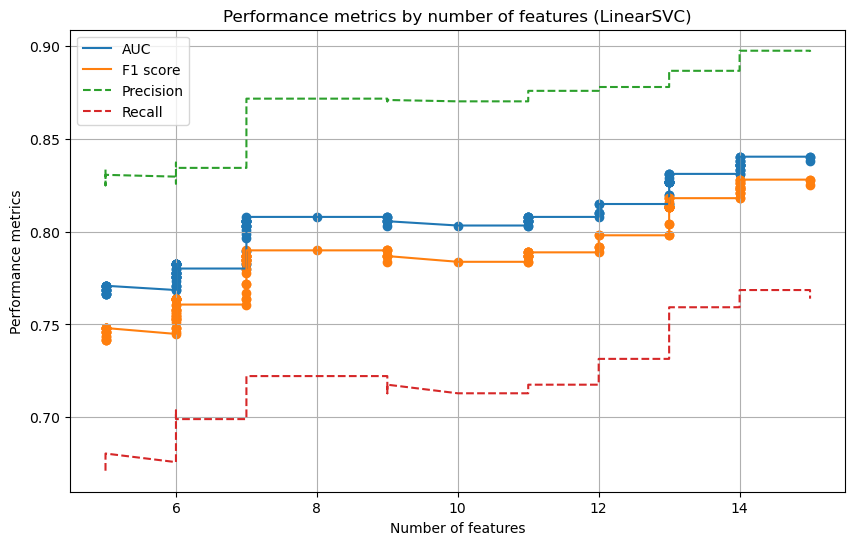

------------------------------------------------------------
ElasticNetCV
best l1_ratio: 0.2056717652757185
selected features: ['ISG15' 'IFI27' 'IFI44L' 'IFIT1' 'OTOF' 'RSAD2' 'HES4' 'OAS3' 'CCL8'
 'IFI44' 'OAS2' 'MX1' 'IFIT3' 'OAS1' 'LY6E' 'XAF1' 'IFIT2' 'PARP12' 'IRF7'
 'JUP' 'ZBP1' 'EPSTI1' 'IFI6' 'SERPING1' 'SAMD9L' 'MT2A' 'DDX58' 'ISG20'
 'TIMM10' 'TMEM123' 'IFITM3' 'NT5C3A' 'GNLY' 'PRF1' 'PARP14' 'GZMH'
 'DRAP1' 'ADGRG1' 'PHF11' 'HBZ' 'GZMB' 'GZMK' 'GZMA' 'MYOM2' 'IGLL1'
 'JCHAIN' 'SHISA5' 'BST2' 'NKG7' 'ITM2C' 'TXNDC5;BLOC1S5-TXNDC5' 'LAP3'
 'CTSL' 'MAP4K1' 'GBP4' 'GBP1' '38231' 'UBE2L6' 'SLAMF6' 'RUNX3' 'CD79B'
 'IGLL3P' 'CD247' 'PRKCH' 'CMC2' 'CD3D' 'IFITM1' 'CCL5' 'ADA2' 'STAT1'
 'PTPRCAP' 'FCMR' 'DUSP19' 'ZNF683' 'LGALS9' 'TNFSF13B' 'CX3CR1' 'SLC27A3'
 'GIMAP6' 'PRR5' 'ADAR' 'HCP5' 'AES' 'DNAAF1' 'TNK2' 'IFI16' 'SLC38A1'
 'LIME1' 'HCST' 'KRT1' 'DENND2D' 'CSRNP1' 'TMEM140' 'CD81' 'WDFY1' 'LYAR'
 'FCGBP' 'LAT' 'HLA-DRB1' 'ITM2A' 'PSMA5' 'CDKN1A' 'MYL12A' 'TAP1' 'TUBB'
 'GVINP1

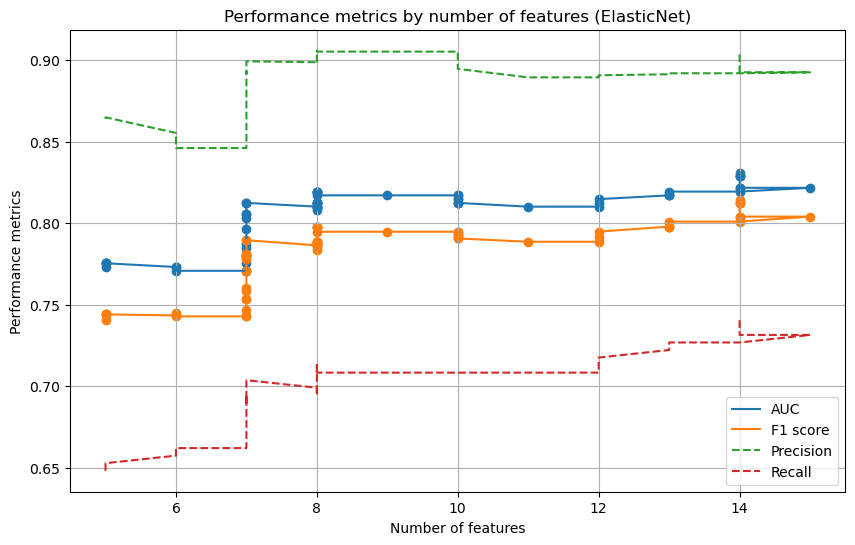

------------------------------------------------------------
LogisticRegressionCV
best C: [10000.]


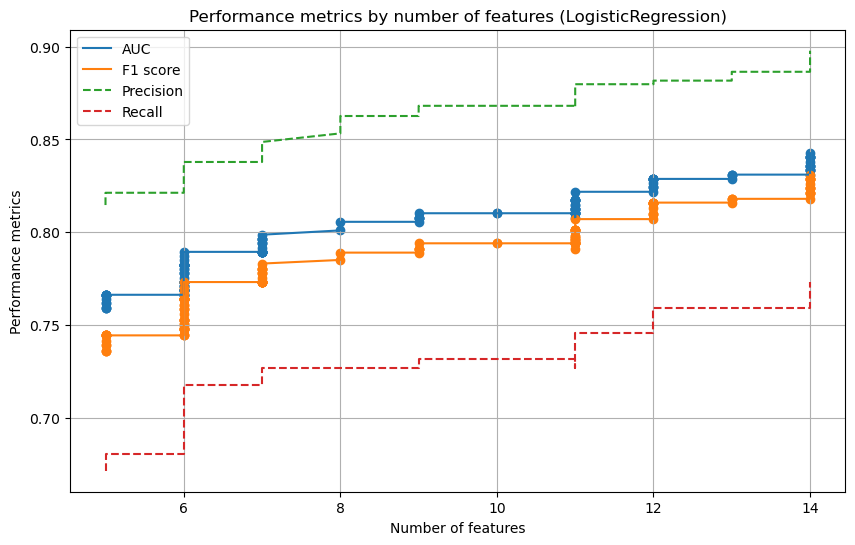

------------------------------------------------------------
LassoCV
best alpha: 1.008240841679117
selected features: ['ISG15' 'IFI27' 'IFI44L' 'IFIT1' 'OTOF' 'RSAD2' 'HES4' 'OAS3' 'CCL8'
 'IFI44' 'OAS2' 'MX1' 'IFIT3' 'OAS1' 'LY6E' 'XAF1' 'IFIT2' 'PARP12' 'IRF7'
 'JUP' 'ZBP1' 'EPSTI1' 'IFI6' 'SERPING1' 'SAMD9L' 'MT2A' 'DDX58' 'ISG20'
 'TIMM10' 'TMEM123' 'IFITM3' 'NT5C3A' 'GNLY' 'PRF1' 'PARP14' 'GZMH'
 'DRAP1' 'ADGRG1' 'PHF11' 'HBZ' 'GZMB' 'GZMK' 'GZMA' 'MYOM2' 'IGLL1'
 'JCHAIN' 'SHISA5' 'BST2' 'NKG7' 'ITM2C' 'TXNDC5;BLOC1S5-TXNDC5' 'LAP3'
 'CTSL' 'MAP4K1' 'GBP4' 'GBP1' '38231' 'UBE2L6' 'SLAMF6' 'RUNX3' 'CD79B'
 'IGLL3P' 'CD247' 'PRKCH' 'CMC2' 'CD3D' 'IFITM1' 'CCL5' 'ADA2' 'STAT1'
 'PTPRCAP' 'FCMR' 'DUSP19' 'ZNF683' 'LGALS9' 'TNFSF13B' 'CX3CR1' 'SLC27A3'
 'GIMAP6' 'PRR5' 'ADAR' 'HCP5' 'AES' 'DNAAF1' 'TNK2' 'IFI16' 'SLC38A1'
 'LIME1' 'HCST' 'KRT1' 'DENND2D' 'CSRNP1' 'TMEM140' 'CD81' 'WDFY1' 'LYAR'
 'FCGBP' 'LAT' 'HLA-DRB1' 'ITM2A' 'PSMA5' 'CDKN1A' 'MYL12A' 'TAP1' 'TUBB'
 'GVINP1' 'HMGN1'

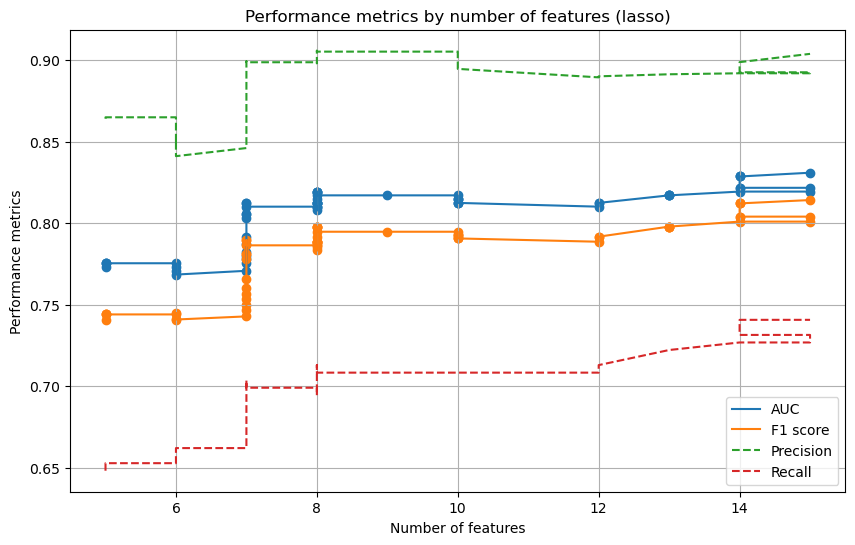

In [32]:
final_results = pd.DataFrame(columns=['method', 'model', 'n', 'acc', 'auc', 'f1', 'precision', 'recall', 'f2','f05', 'confusionmatrix','coef', 'coef_rounded', 'found_coef', 'multiple_times','delta','intercept','balanced', 'gene_id', 'gene_symbol', 'gb_acc'])
max_run_num = 2000
C_values = np.logspace(-9, 0, num=max_run_num, base=10)
alpha_values = np.logspace(15, -5, num=max_run_num, base=10)

# LinearSVC
lsvc = LinearSVC(penalty="l1", dual=False)
lsvc_params = [{'C': C} for C in C_values]
evaluate_classifier(lsvc, 'LinearSVC', 'lsvc', X_train, y_train, X_test, y_test, lsvc_params)
# Elastic-Net
encv = ElasticNetCV(l1_ratio=1-np.logspace(-3, -0.1, num=10, base=10), n_alphas=200, max_iter=5000, n_jobs=10, selection='cyclic')
encv.fit(X_train, y_train)
print('-'*60)
print('ElasticNetCV')
print('best l1_ratio:', encv.l1_ratio_)
print('selected features:', X_train.columns[encv.coef_ != 0].values)
print('n features:', encv.n_features_in_)
en = ElasticNet(alpha=0.1, l1_ratio=encv.l1_ratio_, max_iter=5000, selection='cyclic')
en_params = [{'alpha': alpha} for alpha in alpha_values]
evaluate_classifier(en, 'ElasticNet', 'en', X_train, y_train, X_test, y_test, en_params)
# LogisticRegression
lrcv = LogisticRegressionCV(penalty='l1', solver='liblinear', max_iter=10000, n_jobs=-1)
lrcv.fit(X_train, y_train)
print('-'*60)
print('LogisticRegressionCV')
print('best C:', lrcv.C_)
# print('selected features:', X_train.columns[lrcv.coef_ != 0].values)
# print('n features:', lrcv.n_features_in_)
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr_params = [{'C': C} for C in C_values]
evaluate_classifier(lr, 'LogisticRegression', 'lr', X_train, y_train, X_test, y_test, lr_params)
# Lasso
lassocv = LassoCV(max_iter=5000, n_jobs=-1)
lassocv.fit(X_train, y_train)
print('-'*60)
print('LassoCV')
print('best alpha:', lassocv.alpha_)
print('selected features:', X_train.columns[lassocv.coef_ != 0].values)
print('n features:', lassocv.n_features_in_)
lasso = Lasso(alpha=0.1, max_iter=5000)
lasso_params = [{'alpha': alpha} for alpha in alpha_values]
evaluate_classifier(lasso, 'lasso', 'lasso', X_train, y_train, X_test, y_test, lasso_params)


In [33]:
# 重新排序
sort_columns = ['found_coef','f1', 'auc',  'balanced','n', 'delta']
sort_order = [False,False, False, False,True, True]

# Sort the DataFrame
results_sorted = final_results.sort_values(by=sort_columns, ascending=sort_order).reset_index(drop=True).copy()
results_sorted_view = results_sorted.head(5).copy().drop(['coef','gene_id','intercept','multiple_times'], axis=1)
# results_sorted_view

# 复制 'final_results' 到 'final_results_unique' 
final_results_unique = results_sorted.copy()

# 将 'coef_rounded' 和 'gene_id' 列转化为字符串
final_results_unique['coef_rounded'] = final_results_unique['coef_rounded'].astype('str')
final_results_unique['gene_id'] = final_results_unique['gene_id'].astype('str')

# 删除重复行
final_results_unique.drop_duplicates(subset=['coef_rounded', 'gene_id'], keep='first', inplace=True)
final_results_unique['coef_rounded'] = final_results_unique['coef_rounded'].apply(ast.literal_eval)
final_results_unique['gene_id'] = final_results_unique['gene_id'].apply(ast.literal_eval)

In [34]:
# reproduce
results_sorted_found_coef = final_results_unique[results_sorted['found_coef'] == True].reset_index(drop=True).copy()
reperduce = []
for i in range(len(results_sorted_found_coef)):
    gene_ids = results_sorted_found_coef['gene_id'][i]
    # check if gene_ids are in X_test columns
    if set(gene_ids).issubset(set(X_test.columns)):
        X_test_selected = X_test[gene_ids].copy()
    else:
        # modify gene_ids to match X_test columns
        gene_ids = [col for col in gene_ids if col in X_test.columns]
        X_test_selected = X_test[gene_ids].copy()
    y_test_selected = y_test
    # calculate score
    coef = results_sorted_found_coef['coef_rounded'][i]
    times = results_sorted_found_coef['multiple_times'][i]
    intercept = results_sorted_found_coef['intercept'][i]
    model_name = results_sorted_found_coef['model'][i]

    scores = []
    predictions = []
    
    # determine model and calculate scores and predictions
    if model_name == 'LinearRegression':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'RidgeClassifier' or model_name == 'RidgeClassifierCV':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'LogisticRegression' or model_name == 'LogisticRegressionCV':
        for j in range(len(X_test_selected)):
            z = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            score = 1 / (1 + np.exp(-z))
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'Lasso' or model_name == 'LassoCV':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[[j]], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'LinearSVC' or model_name == 'NuSVC':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'ElasticNet':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[[j]], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'SGDClassifier':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    else:
        # handle SVC
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
        
    # calculate evaluation metrics
    acc = accuracy_score(y_test_selected, predictions)
    auc = roc_auc_score(y_test_selected, scores)
    f1 = f1_score(y_test_selected, predictions)
    precision = precision_score(y_test_selected, predictions)
    recall = recall_score(y_test_selected, predictions)

    # 能复现
    can_reproduce = True

    # if not acc == results_sorted_found_coef['acc'][i]:
    #     can_reproduce = False
    #     # print results
    #     print('Model:', model_name, 'n:', results_sorted_found_coef['n'][i],'acc:', acc, 'auc:', auc, 'f1:', f1, 'precision:', precision, 'recall:', recall)
    #     print(acc)
    #     print(results_sorted_found_coef['acc'][i])
    
    reperduce.append(can_reproduce)

results_sorted_found_coef['reproduce'] = reperduce
results_sorted_found_coef_view = results_sorted_found_coef[results_sorted_found_coef['reproduce'] == True][results_sorted_found_coef['n'] <= 15].copy().drop(['coef','gene_id','intercept','multiple_times'], axis=1)
results_sorted_found_coef_view.head(5)
    

,method,model,n,acc,auc,f1,precision,recall,f2,f05,confusionmatrix,coef_rounded,found_coef,delta,balanced,gene_symbol,gb_acc,reproduce
0,LogisticRegression,lr,14,0.842593,0.842593,0.830846,0.897849,0.773148,0.795238,0.869792,"[[197, 19], [49, 167]]","[4.0, 25.0, 1.0, -12.0, 6.0, 10.0, -2.0, -8.0,...",True,0.117376,False,"[IFI27, MX1, IGLL1, UBE2L6, CCL5, KLF2, CSF3R,...","[IFI27, MX1, IGLL1, UBE2L6, CCL5, KLF2, CSF3R,...",True
1,LogisticRegression,lr,14,0.840278,0.840278,0.828784,0.893048,0.773148,0.794481,0.866183,"[[196, 20], [49, 167]]","[4.0, 25.0, 1.0, -12.0, 6.0, 10.0, -2.0, -8.0,...",True,0.115551,False,"[IFI27, MX1, IGLL1, UBE2L6, CCL5, KLF2, CSF3R,...","[IFI27, MX1, IGLL1, UBE2L6, CCL5, KLF2, CSF3R,...",True
2,LogisticRegression,lr,14,0.840278,0.840278,0.828784,0.893048,0.773148,0.794481,0.866183,"[[196, 20], [49, 167]]","[4.0, 25.0, 1.0, -12.0, 6.0, 10.0, -2.0, -8.0,...",True,0.115906,False,"[IFI27, MX1, IGLL1, UBE2L6, CCL5, KLF2, CSF3R,...","[IFI27, MX1, IGLL1, UBE2L6, CCL5, KLF2, CSF3R,...",True
3,LogisticRegression,lr,14,0.840278,0.840278,0.828784,0.893048,0.773148,0.794481,0.866183,"[[196, 20], [49, 167]]","[4.0, 25.0, 1.0, -10.0, 6.0, 10.0, -2.0, -8.0,...",True,0.123895,False,"[IFI27, MX1, IGLL1, UBE2L6, CCL5, KLF2, CSF3R,...","[IFI27, MX1, IGLL1, UBE2L6, CCL5, KLF2, CSF3R,...",True
4,LogisticRegression,lr,14,0.840278,0.840278,0.828784,0.893048,0.773148,0.794481,0.866183,"[[196, 20], [49, 167]]","[4.0, 25.0, 1.0, -10.0, 6.0, 10.0, -2.0, -8.0,...",True,0.132972,False,"[IFI27, MX1, IGLL1, UBE2L6, CCL5, KLF2, CSF3R,...","[IFI27, MX1, IGLL1, UBE2L6, CCL5, KLF2, CSF3R,...",True


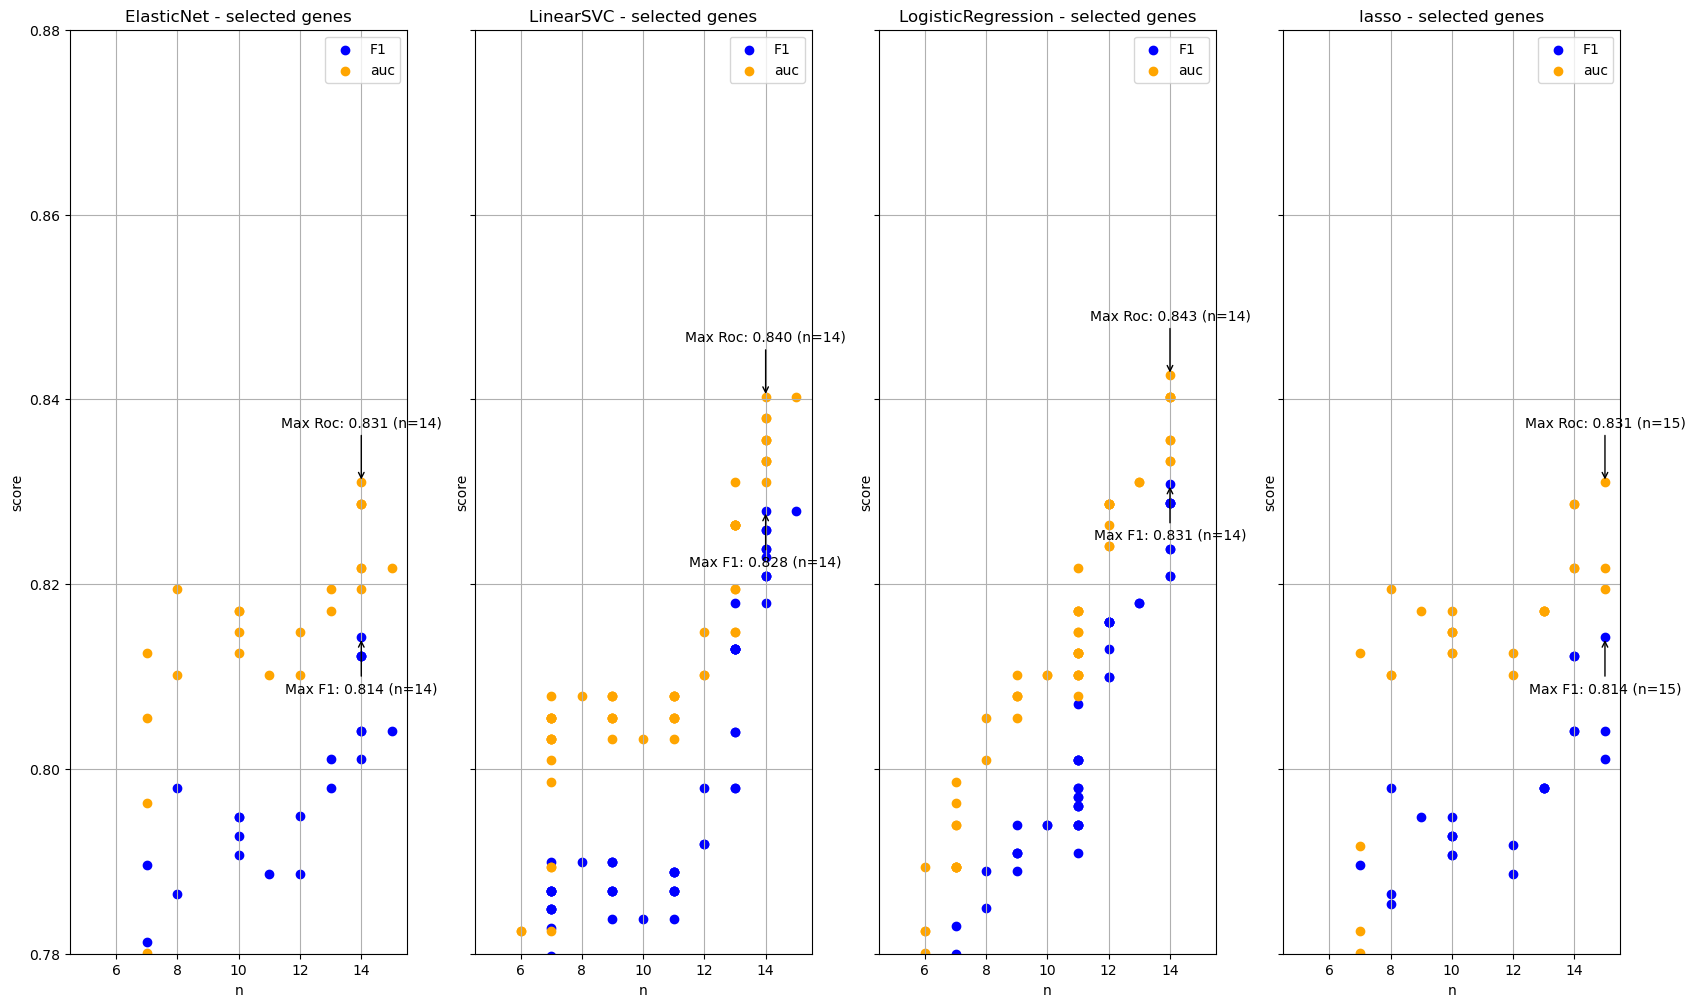

In [35]:
# for results_sorted_found_coef, draw the figure
# Group the results by method and model
# filter by n
results_sorted_found_coef_n = results_sorted_found_coef[results_sorted_found_coef['n'] <= 25]
groups = results_sorted_found_coef_n.groupby(['method'])
methods = [method for method, _ in groups]
# Create a figure with multiple subplots
fig, axs = plt.subplots(1,len(methods), sharex=True, sharey=True, figsize=(20, 12))

# Iterate over the subplots and plot the acc and roc values
for i, method in enumerate(methods):
    group = groups.get_group(method)
    axs[i].scatter(group['n'], group['f1'], label='F1', color='blue')
    axs[i].scatter(group['n'], group['auc'], label='auc', color='orange')
    axs[i].set_xlabel('n')
    axs[i].set_ylabel('score')
    axs[i].set_ylim([0.78, 0.88]) # Set y-axis limits
    axs[i].legend()
    # Find the maximum acc and roc values for this method and model
    max_acc_idx = group['f1'].idxmax()
    max_auc_idx = group['auc'].idxmax()
    max_acc = group.loc[max_acc_idx, 'f1']
    max_auc = group.loc[max_auc_idx, 'auc']
    max_n_acc = group.loc[max_acc_idx, 'n']
    max_n_auc = group.loc[max_auc_idx, 'n']

    # Add annotations with the maximum acc and roc values
    axs[i].annotate(f'Max F1: {max_acc:.3f} (n={max_n_acc})',
                        xy=(max_n_acc, max_acc),
                        xytext=(max_n_acc, max_acc - 0.006),
                        ha='center',
                        arrowprops=dict(arrowstyle='->'))
    axs[i].annotate(f'Max Roc: {max_auc:.3f} (n={max_n_auc})',
                        xy=(max_n_auc, max_auc),
                        xytext=(max_n_auc, max_auc + 0.006),
                        ha='center',
                        arrowprops=dict(arrowstyle='->'))

    axs[i].set_title(f'{method} - selected genes')
    # grid
    axs[i].grid()

# 测试

In [36]:
import string

def remove_last_digit(symbol):
    return symbol[:-1] if symbol and symbol[-1] in string.digits else symbol

def process_symbol(table, symbol, columns):
    symbol_processed = symbol
    for _ in range(10):  # Arbitrary number to prevent infinite loops
        try:
            alias[symbol] = symbol_processed
            return extract_genomic_info(table, symbol_processed, columns), symbol_processed
        except IndexError:
            symbol_processed = remove_last_digit(symbol_processed)
    return None, symbol

def get_symbol(symbol):
    return symbol.split(';')[0] if ';' in symbol else symbol

def extract_genomic_info(table, symbol, gene_columns):
    return {col: table[table['Symbol'] == symbol][col].values[0] for col in gene_columns}

def update_gene_data(gene_data, symbol, weight):
    index = gene_data[gene_data['gene_symbol'] == symbol].index.tolist()[0]
    gene_data.loc[index, 'count'] += 1
    gene_data.loc[index, 'weights'].append(weight)
    gene_data.loc[index, 'avg_weights'] = np.mean(gene_data.loc[index, 'weights'])

def add_new_gene(gene_data, genomic_info):
    new_data = pd.DataFrame({**{'gene_symbol' : [genomic_info['symbol']],
                                'count': [1],
                                'weights': [[genomic_info['weight']]],
                                'avg_weights': [genomic_info['weight']]},
                             **{k: [v] for k, v in genomic_info.items() if k != 'symbol' and k != 'weight'}})
    gene_data = pd.concat([gene_data, new_data], ignore_index=True)
    return gene_data

stored = set()
gene_data = pd.DataFrame()
gene_symbols = results_sorted_found_coef_view['gene_symbol'].tolist()
gene_columns = ['GB_ACC', 'ID', 'Definition', 'SEQUENCE', 'Ontology_Component', 'Ontology_Process', 'Ontology_Function', 'Synonyms']
alias = dict()
for i in range(len(gene_symbols)):
    for j in range(len(gene_symbols[i])):
        symbol = get_symbol(gene_symbols[i][j])

        if symbol in stored:
            stored_symbol = alias[symbol]
            update_gene_data(gene_data, stored_symbol, results_sorted_found_coef_view['coef_rounded'][i][j])
            continue
            
        genomic_info, symbol_found = process_symbol(gpl.table, symbol, gene_columns)
        if not genomic_info:
            continue  # If we still did not find a match after removing all possible digits

        genomic_info['symbol'] = symbol_found
        genomic_info['weight'] = results_sorted_found_coef_view['coef_rounded'][i][j]
        gene_data = add_new_gene(gene_data, genomic_info)
        stored.add(symbol)

# if gene_data.gene_symbol is not unique, then merge them
gene_data = gene_data.sort_values(by=['avg_weights'], ascending=False).reset_index(drop=True)
gene_data

,gene_symbol,count,weights,avg_weights,GB_ACC,ID,Definition,SEQUENCE,Ontology_Component,Ontology_Process,Ontology_Function,Synonyms
0,MX1,214,"[25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25....",23.065421,NM_002462.2,ILMN_1662358,Homo sapiens myxovirus (influenza virus) resis...,ACCCAGTGTTTTAGGAGCATGAGTGCCGTGTGTGTGCGTCCTGTCG...,All of the contents of a cell excluding the pl...,A process that directly activates any of the s...,"Interacting selectively with a nucleotide, any...",MxA; IFI78; MX; IFI-78K
1,KLF2,199,"[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....",8.100503,NM_016270.2,ILMN_1735930,Homo sapiens Kruppel-like factor 2 (lung) (KLF...,ATTACTGTACATAGAGAGACAGGTGGGCATTTTTGGGCTACCTGGT...,The living contents of a cell; the matter cont...,"Any process that modulates the frequency, rate...",The function of binding to a specific DNA sequ...,LKLF
2,CCL5,214,"[6.0, 6.0, 6.0, 6.0, 6.0, 8.0, 8.0, 8.0, 8.0, ...",6.177570,NM_002985.2,ILMN_1773352,Homo sapiens chemokine (C-C motif) ligand 5 (C...,ATTTGCCTGTTTCTGCTTGCTCTTGTCCTAGCTTGGGAGGCTTCCC...,The space external to the outermost structure ...,"The regulation of the levels, transport, and m...",Mediates the transfer of a signal from the out...,TCP228; SISd; MGC17164; SCYA5; RANTES; D17S136E
3,IFI27,214,"[4.0, 4.0, 4.0, 4.0, 4.0, 3.0, 3.0, 3.0, 4.0, ...",5.280374,NM_005532.3,ILMN_2058782,"Homo sapiens interferon, alpha-inducible prote...",CCAAGTTCATCCTGGGCTCCATTGGGTCTGCCATTGCGGCTGTCAT...,Double layer of lipid molecules that encloses ...,Any process specifically pertinent to the func...,"Elemental activities, such as catalysis or bin...",FAM14D; P27; ISG12
4,TMEM17,25,"[3.0, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 2.0, 3.0, ...",2.560000,NM_198276.1,ILMN_1783583,Homo sapiens transmembrane protein 17 (TMEM17)...,GACTTTGACCGGCTCTCTGCAAACAGAGGAGACATGAGAAGGATGA...,Double layer of lipid molecules that encloses ...,NaN,NaN,FLJ34583
5,ALPL,20,"[3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 4.0, 2.0, 2.0, ...",2.000000,NM_000478.3,ILMN_1701603,"Homo sapiens alkaline phosphatase, liver/bone/...",TCACACTCCTGGGCTCTGAACACACACGCCAGCTCCTCTCTGAAGC...,The membrane surrounding a cell that separates...,"The chemical reactions and pathways, including...",Catalysis of a biochemical reaction at physiol...,TNSALP; HOPS; FLJ40094; AP-TNAP; TNAP; MGC161443
6,IGLL1,92,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.423913,NM_152855.1,ILMN_1656713,Homo sapiens immunoglobulin lambda-like polype...,TCTGGCCGTGGTAACCCATGGCCTGCTGCGCCCAACAGCTGCATCG...,The space external to the outermost structure ...,Any immune system process that functions in th...,NaN,IGO; IGVPB; IGLL; CD179b; IGL1; VPREB2; IGL5; ...
7,S100A12,1,[1.0],1.000000,NM_005621.1,ILMN_1748915,Homo sapiens S100 calcium binding protein A12 ...,TCCAAGGCCTGGATGCTAATCAAGATGAACAGGTCGACTTTCAAGA...,"That fraction of cells, prepared by disruptive...",The chemical reactions and pathways involving ...,Interacting selectively with calcium ions (Ca2...,CAAF1; CAGC; ENRAGE; p6; CGRP; MRP6
8,CPVL,1,[-1.0],-1.000000,NM_019029.2,ILMN_1682928,"Homo sapiens carboxypeptidase, vitellogenic-li...",CTCCTTGATGGGCATGGACTGGAAAGGATCCCAGGAATACAAGAAG...,NaN,The hydrolysis of a peptide bond or bonds with...,Catalysis of the hydrolysis of a peptide bond ...,HVLP; MGC10029
9,FCER1G,10,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",-1.000000,NM_004106.1,ILMN_2123743,"Homo sapiens Fc fragment of IgE, high affinity...",TGTTTACACGGGCCTGAGCACCAGGAACCAGGAGACTTACGAGACT...,The membrane surrounding a cell that separates...,Any process that activates or increases the fr...,Combining with an extracellular or intracellul...,NaN


In [37]:
# import excel 
from openpyxl import load_workbook
wb = load_workbook('feature.xlsx')
ws = wb.active
ws = wb['Sheet1']
# remove all rows
ws.delete_rows(1, ws.max_row)
# write column name
for col in range(len(gene_data.columns)):
    ws.cell(row=1, column=col+1, value=gene_data.columns[col])
# write data
for i in range(len(gene_data)):
    for col in range(len(gene_data.columns)):
        # not NaN
        if gene_data.iloc[i, col] == '':
            ws.cell(row=i+2, column=col+1, value='N/A')
        else:
            try:
                ws.cell(row=i+2, column=col+1, value=gene_data.iloc[i, col])
            except ValueError:
                ws.cell(row=i+2, column=col+1, value=str(gene_data.iloc[i, col]))
# save

wb.save('feature.xlsx')

### 我们的模型

In [38]:
# 选择的模型
best_model = results_sorted_found_coef.iloc[0].copy()
weight = best_model.coef_rounded
feature =  best_model.gene_symbol
times = best_model.multiple_times
intercept = best_model.intercept
model = best_model.model

# 实际输入的模型
print('feature:', feature)
print('weight:', weight)

# up means weight > 0
# down means weight < 0
up_feature = []
up_weight = []
down_feature = []
down_weight = []
for i in range(len(weight)):
    if weight[i] > 0:
        up_feature.append(feature[i])
        up_weight.append(weight[i])
    else:
        down_feature.append(feature[i])
        down_weight.append(-1*weight[i])
up_times = times
down_times = times
up_intercept = best_model.intercept
down_intercept = best_model.intercept
up_model = best_model.intercept
down_model = best_model.intercept

feature: ['IFI27', 'MX1', 'IGLL1', 'UBE2L6', 'CCL5', 'KLF2', 'CSF3R', 'GAPDH', 'TALDO1', 'FCGR2A', 'VCAN', 'SOD2', 'ALPL', 'PI3']
weight: [4.0, 25.0, 1.0, -12.0, 6.0, 10.0, -2.0, -8.0, -5.0, -16.0, -8.0, -3.0, 3.0, -4.0]


# 导出至Excel

In [39]:
wb.save('feature.xlsx')